# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [1]:
!nvidia-smi

Mon Aug 28 13:41:26 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    434MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


### Load in the data.

In [ ]:
%%time
# This is how the ACTS data was cleaned.
# Don't run this cell unless you want to overwrite the current cleaned data.
mapper = {}
for key in range(  30,   35): mapper[key] = 32
for key in range(  70,   75): mapper[key] = 72
for key in range( 115,  120): mapper[key] = 117
for key in range( 170,  175): mapper[key] = 172
for key in range( 255,  270): mapper[key] = 260
for key in range( 355,  370): mapper[key] = 360
for key in range( 495,  510): mapper[key] = 500
for key in range( 655,  670): mapper[key] = 660
for key in range( 815,  830): mapper[key] = 820
for key in range(1010, 1030): mapper[key] = 1020

print("Loading in the frame.")
filepath   = "data/sets/progenitors/ACTS.gz"
events     = utils.list_of_groups(pd.read_csv(filepath), "event_id")
frame      = pd.concat([event for event in events if metrics.number_of_tracks(event) <= 25])
frame["r"] = frame["r"].round().map(mapper)
frame.drop_duplicates(["event_id", "cluster_id", "r"], keep="first", inplace=True)
print("Preparing the frame.")
frame = ext.prepare_frame(frame, n_tracks=25, n_rows=260, n_noise=10)
frame = frame.sample(frac=1)
print(frame["cluster_id"].max())
print("Saving the frame.")
frame.to_csv("data/sets/ACTS-10N-25T.gz", compression="gzip")

In [3]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R.h5"
filepath  = "data/sets/ACTS-10N-25T.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py") 

Train is list of 13232 events.
Test is list of 3308 events.
CPU times: user 6.66 s, sys: 212 ms, total: 6.88 s
Wall time: 6.89 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [5]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 230 events with 1 tracks.
There are 266 events with 2 tracks.
There are 334 events with 3 tracks.
There are 361 events with 4 tracks.
There are 405 events with 5 tracks.
There are 430 events with 6 tracks.
There are 456 events with 7 tracks.
There are 471 events with 8 tracks.
There are 457 events with 9 tracks.
There are 517 events with 10 tracks.
There are 490 events with 11 tracks.
There are 495 events with 12 tracks.
There are 537 events with 13 tracks.
There are 575 events with 14 tracks.
There are 625 events with 15 tracks.
There are 636 events with 16 tracks.
There are 628 events with 17 tracks.
There are 644 events with 18 tracks.
There are 662 events with 19 tracks.
There are 670 events with 20 tracks.
There are 629 events with 21 tracks.
There are 691 events with 22 tracks.
There are 676 events with 23 tracks.
There are 661 events with 24 tracks.
There are 686 events with 25 tracks.


In [6]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 66 events with 1 tracks.
There are 60 events with 2 tracks.
There are 96 events with 3 tracks.
There are 84 events with 4 tracks.
There are 91 events with 5 tracks.
There are 118 events with 6 tracks.
There are 89 events with 7 tracks.
There are 141 events with 8 tracks.
There are 114 events with 9 tracks.
There are 140 events with 10 tracks.
There are 135 events with 11 tracks.
There are 151 events with 12 tracks.
There are 129 events with 13 tracks.
There are 142 events with 14 tracks.
There are 141 events with 15 tracks.
There are 154 events with 16 tracks.
There are 138 events with 17 tracks.
There are 125 events with 18 tracks.
There are 168 events with 19 tracks.
There are 159 events with 20 tracks.
There are 159 events with 21 tracks.
There are 189 events with 22 tracks.
There are 163 events with 23 tracks.
There are 175 events with 24 tracks.
There are 181 events with 25 tracks.


### Show an example of the data.

In [53]:
importlib.reload(visuals)

<module 'tracker.visuals' from '/home/jovyan/work/Fermi-Internship-2017/Track/tracker/visuals.py'>

Train 4087
Number of Hits: 127
Number of Tracks: 17


<IPython.core.display.Javascript object>


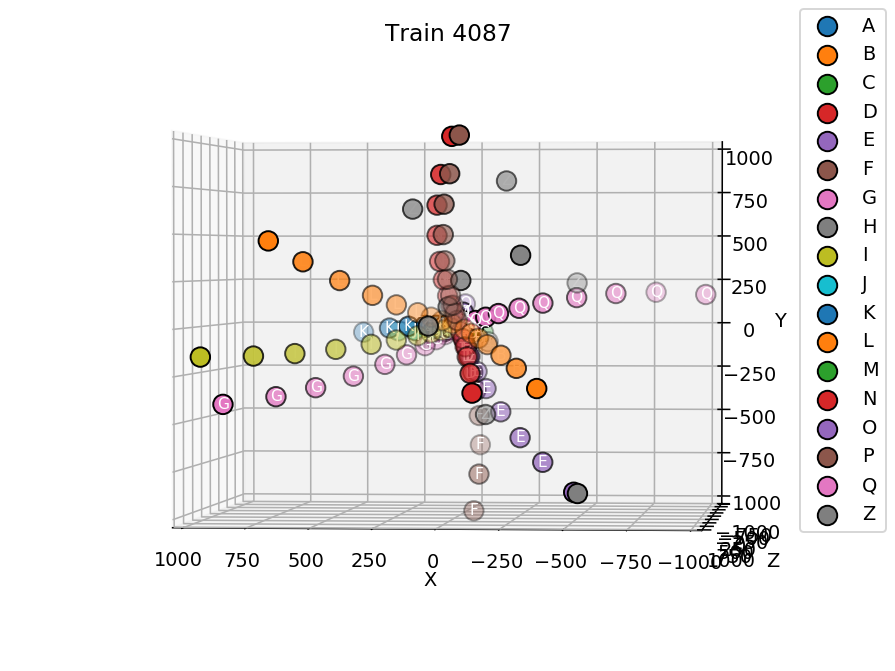

In [59]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot3D(train[n], order).plot(title="Train {}".format(n), z_limits=(-1000, 1000))

<IPython.core.display.Javascript object>


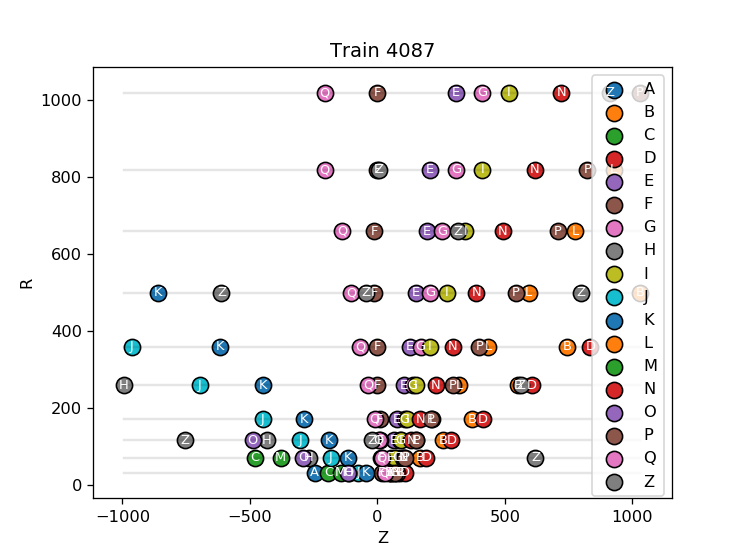

<IPython.core.display.Javascript object>


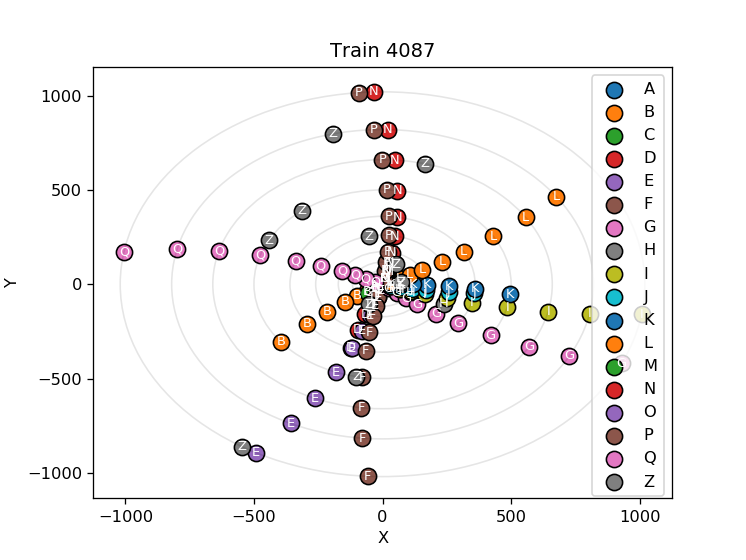

In [62]:
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

### Create the model.

In [8]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 260, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 260, 27)           6939      
Total para

### Fit the model.

In [15]:
%%time
#64+32
epochs     = 32
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

Epoch 1/32
132/132 [==============================] - 212s - loss: 0.2978 - acc: 0.8954 - val_loss: 0.2488 - val_acc: 0.9125
Epoch 2/32
132/132 [==============================] - 208s - loss: 0.2934 - acc: 0.8966 - val_loss: 0.2504 - val_acc: 0.9111
Epoch 3/32
132/132 [==============================] - 209s - loss: 0.2947 - acc: 0.8973 - val_loss: 0.2457 - val_acc: 0.9113
Epoch 4/32
132/132 [==============================] - 208s - loss: 0.2958 - acc: 0.8971 - val_loss: 0.2418 - val_acc: 0.9147
Epoch 5/32
132/132 [==============================] - 208s - loss: 0.2935 - acc: 0.8979 - val_loss: 0.2449 - val_acc: 0.9130
Epoch 6/32
132/132 [==============================] - 209s - loss: 0.2909 - acc: 0.8983 - val_loss: 0.2443 - val_acc: 0.9151
Epoch 7/32
132/132 [==============================] - 208s - loss: 0.2932 - acc: 0.8973 - val_loss: 0.2405 - val_acc: 0.9140
Epoch 8/32
132/132 [==============================] - 207s - loss: 0.2932 - acc: 0.8971 - val_loss: 0.2414 - val_acc: 0.9130


### Display information about the model after fitting it.

In [16]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 79.48700998215112%
Percent of tracks assigned correctly: 67.37648735030228%
Percent of events with the correct number of tracks: 69.19588875453447%
CPU times: user 1min 15s, sys: 768 ms, total: 1min 15s
Wall time: 1min 15s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 89.31297709923665%
Percent of tracks assigned correctly: 80.0%


<IPython.core.display.Javascript object>


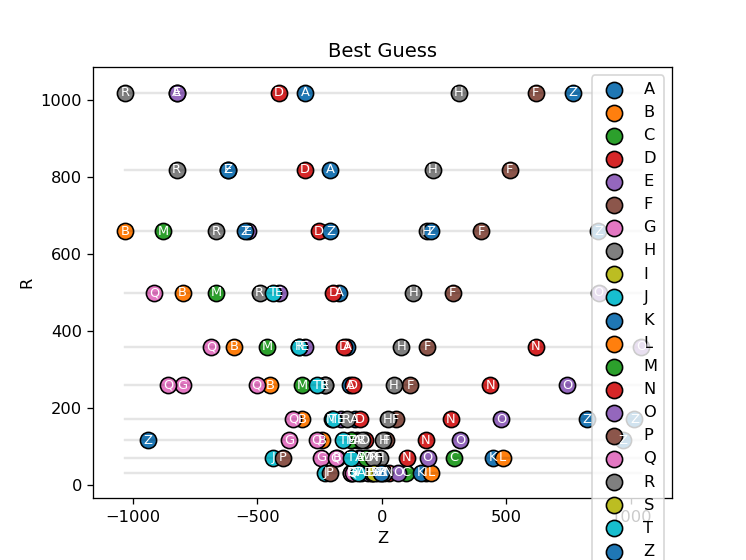

<IPython.core.display.Javascript object>


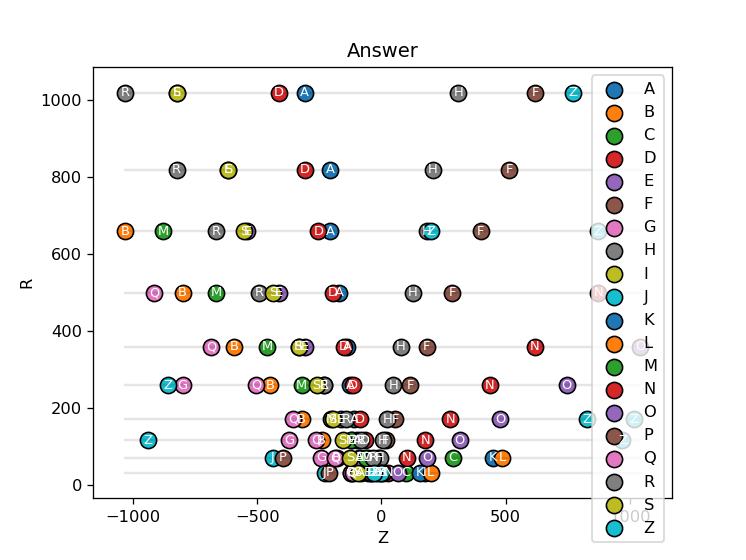

In [48]:
n  = np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Best Guess")
d = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer")

<IPython.core.display.Javascript object>


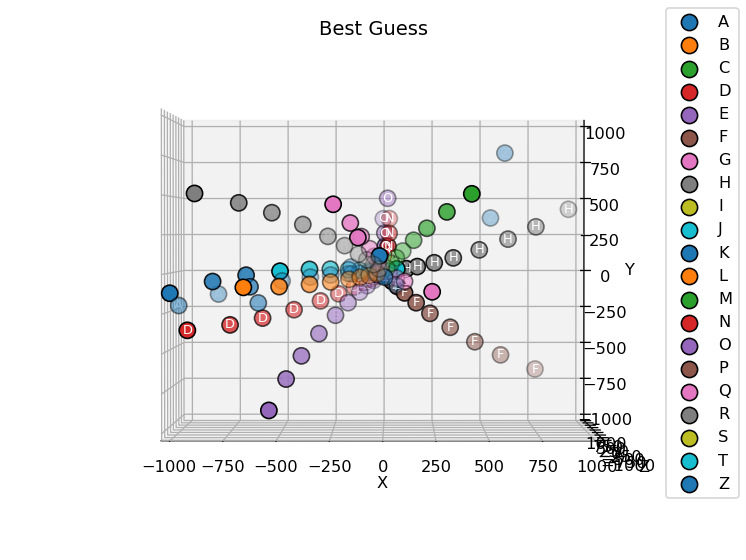

<IPython.core.display.Javascript object>


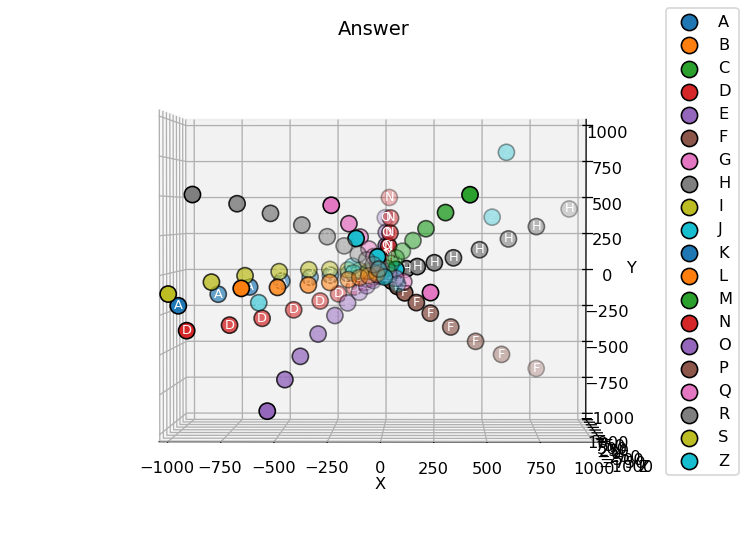

In [49]:
d = visuals.Plot3D(test[n], order, guesses[n]).plot(title="Best Guess", z_limits=(-1000, 1000))
d = visuals.Plot3D(test[n], ["z", "r", "phi"]).plot(title="Answer", z_limits=(-1000, 1000))

In [50]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.125746,660.0,-551.000000,,,,,,,,,,,,,,,,,,,`1`[0],,,,,,,`0`[1],
1,-3.125195,32.0,-83.012700,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
2,-3.117179,72.0,-90.443300,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
3,-3.108653,117.0,-98.619700,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
4,-3.097975,172.0,-109.027000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
5,-3.081186,260.0,-127.000000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
6,-3.080349,820.0,-618.000000,,,,,,,,,,,,,,,,,,,`1`[0],,,,,,,`0`[1],
7,-3.061319,360.0,-139.000000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
8,-3.033963,500.0,-170.000000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
9,-3.022470,1020.0,-824.000000,`0`[1],,,,,,,,,,,,,,,,,,`1`[0],,,,,,,,


<IPython.core.display.Javascript object>


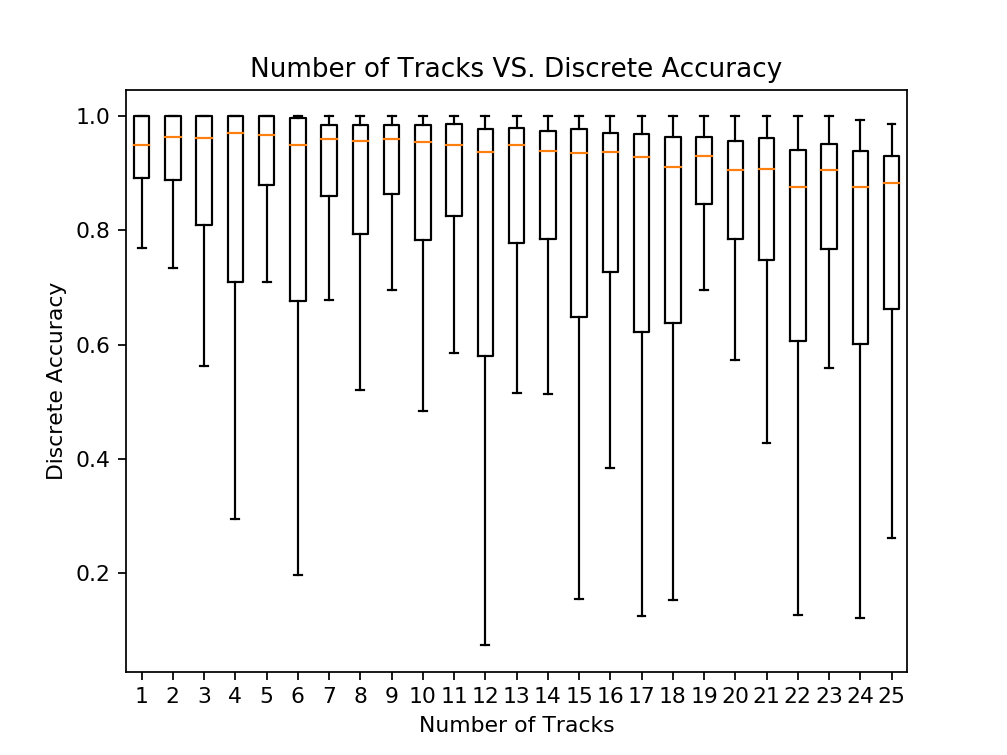

CPU times: user 26.3 s, sys: 16 ms, total: 26.3 s
Wall time: 26.3 s


In [51]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "Number of Tracks VS. Discrete Accuracy", "Number of Tracks", "Discrete Accuracy", xticks=list(r))